#### Objective 1: Identifying psychiatric disorders and psychotropic medications associated with increased ICU readmission.

/var/folders/cm/blwm27yd02l6xpvwrm9_l41m0000gn/T/ipykernel_32592/865082081.py:29: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  rx      = pd.read_csv('./data/psych_prescriptions.csv')


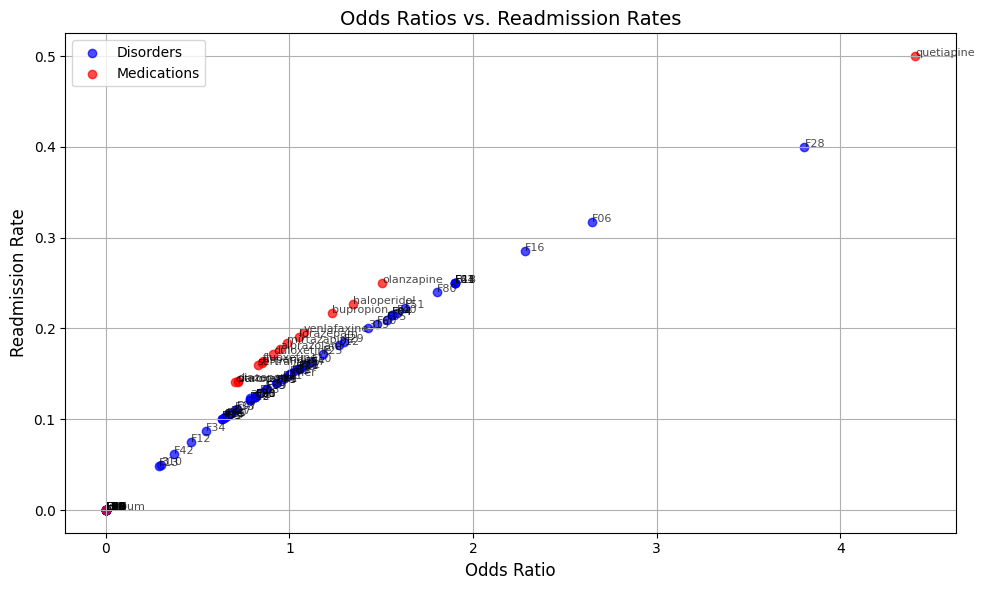

Top 10 disorders with highest odds:
dx_group  n_adm  readm_rate    ci_low  ci_high  odds_ratio  p_value
     F28      5    0.400000 -0.029414 0.829414    3.804412 0.163184
     F06     60    0.316667  0.198961 0.434372    2.648101 0.000883
     F16      7    0.285714 -0.048950 0.620378    2.282543 0.280984
     F44     40    0.250000  0.115808 0.384192    1.903017 0.077520
     F63      8    0.250000 -0.050062 0.550062    1.902076 0.340064
     318      4    0.250000 -0.174352 0.674352    1.901958 0.475866
     F21      4    0.250000 -0.174352 0.674352    1.901958 0.475866
     F80     25    0.240000  0.072583 0.407417    1.802371 0.253177
     F51     36    0.222222  0.086414 0.358031    1.630806 0.237702
     F40     69    0.217391  0.120066 0.314716    1.586012 0.125852

Top 10 medications with highest odds:
       drug  n_adm  readm_rate    ci_low  ci_high  odds_ratio      p_value
 quetiapine      2    0.500000 -0.192965 1.192965    4.406772 3.357460e-01
 olanzapine   1283    0.250

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from statsmodels.stats.contingency_tables import Table2x2
ignore_warnings = True

def icd_group(code: str) -> str:
    """Map ICD code to a disorder group."""
    code = str(code).strip()
    if code.startswith('F'):
        return code[:3]
    try:
        num = int(code.split('.')[0])
        if 290 <= num <= 319:
            return str(num)[:3]
    except ValueError:
        pass
    return 'other'

def rate_ci(k, n, z=1.96):
    """Approximate 95% CI for a proportion (Wald)."""
    p = k / n
    se = np.sqrt(p * (1 - p) / n)
    return p, p - z*se, p + z*se

icu_adm = pd.read_csv('./data/icu_psy_readmissions.csv',
                      parse_dates=['dischtime'])
diag    = pd.read_csv('./data/psych_diagnoses.csv')
rx      = pd.read_csv('./data/psych_prescriptions.csv')

# Group ICD codes into disorder buckets
diag['dx_group'] = diag['icd_code'].apply(icd_group)

# One row per admission/disorder group
adm_dx = (diag[['hadm_id','dx_group']]
          .drop_duplicates()
          .merge(icu_adm[['hadm_id','readmitted_30d']], on='hadm_id'))

results_dx = []
for g, grp in adm_dx.groupby('dx_group'):
    # 2x2 contingency table
    readm_yes = grp['readmitted_30d'].sum()
    readm_no  = grp['readmitted_30d'].size - readm_yes

    other     = adm_dx[adm_dx['dx_group'] != g]
    other_yes = other['readmitted_30d'].sum()
    other_no  = other.shape[0] - other_yes

    table = np.array([[readm_yes, readm_no],
                      [other_yes, other_no]])
    
    OR, p = fisher_exact(table)
    rate, low, high = rate_ci(readm_yes, readm_yes + readm_no)
    results_dx.append((g, readm_yes + readm_no, rate, low, high, OR, p))

dx_stats = (pd.DataFrame(results_dx,
             columns=['dx_group','n_adm','readm_rate',
                      'ci_low','ci_high','odds_ratio','p_value'])
            .sort_values('odds_ratio', ascending=False))
dx_labels = pd.read_csv('./data/hosp/d_icd_diagnoses.csv')

dx_stats.merge(dx_labels[['icd_code','long_title']], 
                 left_on='dx_group', right_on='icd_code',
                 how='left').set_index('dx_group')

# Flags for admissions with psychotropic medications
adm_rx = (rx[['hadm_id','drug']]
          .drop_duplicates()
          .merge(icu_adm[['hadm_id','readmitted_30d']], on='hadm_id'))

results_rx = []
for d, grp in adm_rx.groupby('drug'):
    readm_yes = grp['readmitted_30d'].sum()
    readm_no  = grp.shape[0] - readm_yes

    other     = adm_rx[adm_rx['drug'] != d]
    other_yes = other['readmitted_30d'].sum()
    other_no  = other.shape[0] - other_yes

    table = np.array([[readm_yes, readm_no],
                      [other_yes, other_no]])
    
    OR, p = fisher_exact(table)
    rate, low, high = rate_ci(readm_yes, readm_yes + readm_no)
    results_rx.append((d, readm_yes + readm_no, rate, low, high, OR, p))

rx_stats = (pd.DataFrame(results_rx,
             columns=['drug','n_adm','readm_rate',
                      'ci_low','ci_high','odds_ratio','p_value'])
            .sort_values('odds_ratio', ascending=False))

import matplotlib.pyplot as plt

# Plot odds ratios vs. readmission rates
fig, ax = plt.subplots(figsize=(6, 6))

# Disorders
ax.scatter(dx_stats['odds_ratio'], dx_stats['readm_rate'], color='blue', label='Disorders', alpha=0.7)
for i, txt in enumerate(dx_stats['dx_group']):
    ax.annotate(txt, (dx_stats['odds_ratio'].iloc[i], dx_stats['readm_rate'].iloc[i]), fontsize=8, alpha=0.7)

# Medications
ax.scatter(rx_stats['odds_ratio'], rx_stats['readm_rate'], color='red', label='Medications', alpha=0.7)
for i, txt in enumerate(rx_stats['drug']):
    ax.annotate(txt, (rx_stats['odds_ratio'].iloc[i], rx_stats['readm_rate'].iloc[i]), fontsize=8, alpha=0.7)

ax.set_xlabel('Odds Ratio', fontsize=12)
ax.set_ylabel('Readmission Rate', fontsize=12)
ax.set_title('Odds Ratios vs. Readmission Rates', fontsize=14)
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

print("Top 10 disorders with highest odds:")
print(dx_stats.head(10).to_string(index=False))
print("\nTop 10 medications with highest odds:")
print(rx_stats.head(10).to_string(index=False))


#### Objective 2: Evaluating if discontinuation or improper reconciliation of psychiatric medications at discharge contributes to higher readmission risks.

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
import statsmodels.api as sm

# 1. Load data
icu  = pd.read_csv('./data/icu_psy_readmissions.csv',
                   parse_dates=['dischtime'])  # hadm_id, subject_id, dischtime, readmitted_30d
last = pd.read_csv('./data/last_prescriptions_processed.csv',
                   parse_dates=['last_psych_med_time'])  # hadm_id, last_psych_med_time

# Merge to include only admissions with at least one psych med
cohort = icu.merge(last, on='hadm_id', how='inner').copy()

# 2. Define discontinuation flag
MARGIN = pd.Timedelta('24h')
cohort['psych_discontinued'] = (
    cohort['last_psych_med_time'].notna() & 
    (cohort['last_psych_med_time'] < cohort['dischtime'] - MARGIN)
)

# 3. 2×2 table and Fisher exact test
tbl = pd.crosstab(cohort['psych_discontinued'], cohort['readmitted_30d'])
display(tbl)

OR, p_val = fisher_exact(tbl.values)
print(f"Odds ratio = {OR:0.2f},  p = {p_val:0.4g}")

def rate_ci(k, n, z=1.96):
    p = k / n
    se = np.sqrt(p * (1 - p) / n)
    return p, p - z * se, p + z * se

disc_yes = tbl.loc[True]
disc_no  = tbl.loc[False]

rate_yes, lo_yes, hi_yes = rate_ci(disc_yes[1], disc_yes.sum())
rate_no,  lo_no, hi_no    = rate_ci(disc_no[1], disc_no.sum())

print(f"\n30‑day readmission:")
print(f"  • Discontinued meds  : {rate_yes:0.1%}  (95% CI {lo_yes:0.1%}–{hi_yes:0.1%})")
print(f"  • Continued/tapered  : {rate_no:0.1%}  (95% CI {lo_no:0.1%}–{hi_no:0.1%})")

# 4. Logistic regression
X = pd.DataFrame({
    'disc': cohort['psych_discontinued'].astype(int),
    'const': 1
})
y = cohort['readmitted_30d'].astype(int)

model = sm.Logit(y, X).fit(disp=False)
print(model.summary())


readmitted_30d,False,True
psych_discontinued,,
False,10068,1784
True,2461,685


Odds ratio = 1.57,  p = 1.512e-18

30‑day readmission:
  • Discontinued meds  : 21.8%  (95% CI 20.3%–23.2%)
  • Continued/tapered  : 15.1%  (95% CI 14.4%–15.7%)
                           Logit Regression Results                           
Dep. Variable:         readmitted_30d   No. Observations:                14998
Model:                          Logit   Df Residuals:                    14996
Method:                           MLE   Df Model:                            1
Date:                Tue, 15 Jul 2025   Pseudo R-squ.:                0.005762
Time:                        17:24:22   Log-Likelihood:                -6669.3
converged:                       True   LL-Null:                       -6707.9
Covariance Type:            nonrobust   LLR p-value:                 1.468e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
disc           0.4516      0.050      8.985      

/var/folders/cm/blwm27yd02l6xpvwrm9_l41m0000gn/T/ipykernel_32592/3840431593.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rate_yes, lo_yes, hi_yes = rate_ci(disc_yes[1], disc_yes.sum())
/var/folders/cm/blwm27yd02l6xpvwrm9_l41m0000gn/T/ipykernel_32592/3840431593.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rate_no,  lo_no, hi_no    = rate_ci(disc_no[1], disc_no.sum())


/var/folders/cm/blwm27yd02l6xpvwrm9_l41m0000gn/T/ipykernel_30365/2702095598.py:38: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  rx        = pd.read_csv('./data/psych_prescriptions.csv')


Feature matrix shape: (23007, 86)

Logistic regression:
  Train AUROC: 0.577
  Test  AUROC: 0.585
  Test  AUPRC: 0.303

Gradient Boosting:
  Test AUROC: 0.665
  Test AUPRC: 0.431

Confusion matrix (threshold 0.5, GB):
[[4357   19]
 [1306   66]]

Classification Report:
              precision    recall  f1-score   support

       False      0.769     0.996     0.868      4376
        True      0.776     0.048     0.091      1372

    accuracy                          0.769      5748
   macro avg      0.773     0.522     0.479      5748
weighted avg      0.771     0.769     0.682      5748



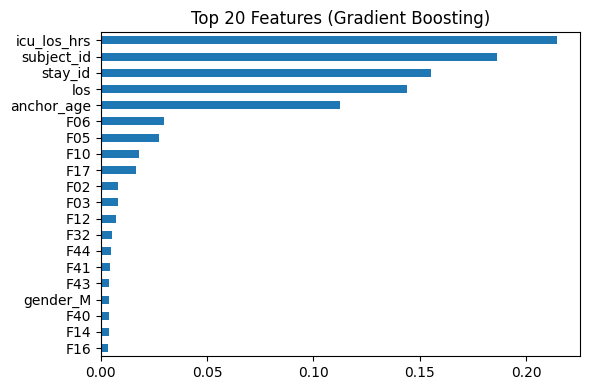

In [4]:
# Top feature influence on 30-day ICU readmission

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

# Disorder buckets (3-digit ICD prefix)
def icd_bucket(code):
    code = str(code).strip()
    if code.startswith('F'):           # ICD-10
        return code[:3]                
    try:                               # ICD-9 codes 290-319
        icd = int(code.split('.')[0])
        if 290 <= icd <= 319:
            return f"{icd:03d}"
    except ValueError:
        pass
    return np.nan 

# 1. Assemble one row per admission with features
base      = pd.read_csv('./data/icu_psy_readmissions.csv',
                        parse_dates=['intime','outtime','dischtime'])
last_rx   = pd.read_csv('./data/last_prescriptions_processed.csv',
                        parse_dates=['last_psych_med_time'])
diag     = pd.read_csv('./data/psych_diagnoses.csv')
diag['dx_group'] = diag['icd_code'].apply(icd_bucket).astype(str)  # cast to str
rx        = pd.read_csv('./data/psych_prescriptions.csv')
patients  = pd.read_csv('./data/hosp/patients.csv', usecols=['subject_id','gender','anchor_age'])

# Outcome
y = base.set_index('hadm_id')['readmitted_30d']

# ICU length of stay (in hours)
base['icu_los_hrs'] = (pd.to_datetime(base['outtime']) - pd.to_datetime(base['intime'])).dt.total_seconds() / 3600

# Medication discontinuation flag
MARGIN = pd.Timedelta('24h')
tmp = last_rx.set_index('hadm_id')['last_psych_med_time']
base = base.join(tmp, on='hadm_id')
base['psych_discontinued'] = (
        base['last_psych_med_time'].notna() &
        (base['last_psych_med_time'] < base['dischtime'] - MARGIN)
)

# Count of psych medications
rx['drug'] = rx['drug'].str.lower()
med_count = (rx.groupby('hadm_id')['drug']
               .agg(n_psych_meds='nunique')
               .reindex(base['hadm_id'])
               .fillna(0)
               .astype(int))
base = base.join(med_count)



diag['dx_group'] = diag['icd_code'].apply(icd_bucket)

dx_buckets = (diag.dropna(subset=['dx_group'])
                 .pivot_table(index='hadm_id',
                              columns='dx_group',
                              values='icd_code',
                              aggfunc='size',
                              fill_value=0,
                              sort=False))
dx_buckets.index = dx_buckets.index.astype('int64', copy=False)

base = base.merge(dx_buckets, left_on='hadm_id', right_index=True, how='left')         
base = base.fillna(0)

# Merge patient info
base = base.merge(patients, on='subject_id', how='left')

# Final feature matrix
X = base.set_index('hadm_id').drop(
        columns=['readmitted_30d','intime','outtime','dischtime',
                 'last_psych_med_time']
     )
print(f"Feature matrix shape: {X.shape}")

# 2. Train/test split by patient
train_ids, test_ids = train_test_split(
        X.index, test_size=0.2, random_state=42,
        stratify=y
)
X_train, X_test = X.loc[train_ids], X.loc[test_ids]
y_train, y_test = y.loc[train_ids], y.loc[test_ids]

# 3. Preprocessing pipeline
num_cols = X.select_dtypes(include=['int','float']).columns.tolist()
cat_cols = ['gender']

pre = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])

# 4-A. L1-regularized Logistic Regression
logreg = Pipeline([
    ('prep', pre),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear',
                               penalty='l1', C=1.0))
])
logreg.fit(X_train, y_train)

pred_train = logreg.predict_proba(X_train)[:,1]
pred_test  = logreg.predict_proba(X_test)[:,1]

print("\nLogistic regression:")
print(f"  Train AUROC: {roc_auc_score(y_train, pred_train):0.3f}")
print(f"  Test  AUROC: {roc_auc_score(y_test , pred_test ):0.3f}")
print(f"  Test  AUPRC: {average_precision_score(y_test, pred_test):0.3f}")

# 4-B. Gradient Boosting Classifier
gb = Pipeline([
    ('prep', pre),
    ('clf', GradientBoostingClassifier(n_estimators=400,
                                       learning_rate=0.05,
                                       max_depth=3,
                                       subsample=0.9,
                                       random_state=42))
])
gb.fit(X_train, y_train)
pred_test_gb = gb.predict_proba(X_test)[:,1]
print("\nGradient Boosting:")
print(f"  Test AUROC: {roc_auc_score(y_test, pred_test_gb):0.3f}")
print(f"  Test AUPRC: {average_precision_score(y_test, pred_test_gb):0.3f}")

# 5. Confusion matrix (GB model at threshold 0.5)
th = 0.5
y_hat = (pred_test_gb >= th).astype(int)
print("\nConfusion matrix (threshold 0.5, GB):")
print(confusion_matrix(y_test, y_hat))
print("\nClassification Report:")
print(classification_report(y_test, y_hat, digits=3))

num_feats = list(pre.transformers_[0][2])
cat_encoder = gb.named_steps['prep'].named_transformers_['cat']
cat_feats   = cat_encoder.get_feature_names_out(cat_cols).tolist()

feature_names = num_feats + cat_feats

# 6. Feature importance plot for GB
imp = gb.named_steps['clf'].feature_importances_

fi  = (pd.Series(imp, index=feature_names)
         .sort_values(ascending=False)[:20])

plt.figure(figsize=(6,4))
fi[::-1].plot(kind='barh')
plt.title("Top 20 Features (Gradient Boosting)")
plt.tight_layout()
plt.show()


Objective 3: Can we combine patient-level features to predict ICU readmission risk? -> which combination of demographics, ICU, severity scores and medication changes is most predictive of readmission?

In [ ]:
import pandas as pd, numpy as np
from pathlib import Path

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler, OneHotEncoder
from sklearn.compose        import ColumnTransformer
from sklearn.pipeline       import Pipeline
from sklearn.linear_model   import LogisticRegression
from sklearn.metrics        import roc_auc_score
from sklearn.inspection     import permutation_importance
from sklearn.model_selection import permutation_test_score

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve
import shap, warnings; warnings.filterwarnings("ignore")

root = Path("./data")

# 1. Load files
base = pd.read_csv(root/"icu_psy_readmissions.csv",
                   parse_dates=["intime","outtime","dischtime","readmitted_30d"])
base = base.drop(columns=["next_admission"])
last_rx = pd.read_csv(root/"last_prescriptions_processed.csv",
                      parse_dates=["last_psych_med_time"])
diag = pd.read_csv(root/"psych_diagnoses.csv")
icu = pd.read_csv("./data/icu/icustays.csv",
                  usecols=["stay_id","subject_id","hadm_id","intime","outtime"],
                  parse_dates=["intime","outtime"])
rx = pd.read_csv("./data/psych_prescriptions.csv",
                 parse_dates=["starttime","stoptime"],
                 low_memory=False)
icu_unique = icu.drop_duplicates(subset=["subject_id", "hadm_id"])

rx = rx.merge(icu_unique, on=["subject_id", "hadm_id"], how="left",
              validate="many_to_one")
rx = rx[(rx["starttime"] >= rx["intime"] - pd.Timedelta("6h")) &
        (rx["starttime"] <= rx["intime"] + pd.Timedelta("1d"))]

patients = pd.read_csv(root/"hosp/patients.csv",
                       usecols=["subject_id","gender","anchor_age"])
sofa = pd.read_csv("./data/derived/first_day_sofa.csv")
sirs = pd.read_csv("./data/derived/sirs.csv")
charlson = pd.read_csv("./data/derived/charlson.csv")
icu = pd.read_csv("./data/icu/icustays.csv",
                  usecols=["stay_id","subject_id","hadm_id"])
diag = pd.read_csv("./data/psych_diagnoses.csv",
                   usecols=["subject_id","hadm_id","icd_code","icd_version","psych_flag"])

# 2. Feature engineering
# Merge ICU info into diagnoses and remove duplicate stays
diag = diag.merge(icu.drop_duplicates(subset=["subject_id", "hadm_id"]),
                  on=["subject_id", "hadm_id"],
                  how="left", validate="many_to_one")
diag.sort_values(["subject_id", "hadm_id", "psych_flag"],
                 ascending=[True, True, False], inplace=True)
diag = diag.drop_duplicates(subset=["subject_id","hadm_id"], keep="first")

# a. One-hot encode diagnosis groups (first 3 characters)
def icd_bucket(code: str) -> str:
    return str(code)[:3]
diag["dx_group"] = diag["icd_code"].map(icd_bucket)
dx_onehot = (diag.groupby(["stay_id", "dx_group"])
               .size().unstack(fill_value=0)
               .add_prefix("dx_")
               .reset_index())

# b. Count prescriptions per stay
rx_cnt = (rx.groupby("stay_id")
          .agg(n_psych_meds=("drug", "nunique"),
               total_psych_doses=("doses_per_24_hrs", "sum"),
               iv_route_used=("route", lambda r: int((r=="IV").any())),
               max_daily_dose=("doses_per_24_hrs", "max"))
          .reset_index())

# c. Compute gap (hours) between discharge and last med time
gap = (base[["stay_id", "hadm_id", "dischtime"]]
       .merge(last_rx, on="hadm_id", how="left", validate="many_to_one")
       .assign(gap_hr=lambda d: (d["dischtime"] - d["last_psych_med_time"]).dt.total_seconds()/3600)
       .loc[:, ["stay_id", "gap_hr"]])

# 3. Merge all data
df = (base.merge(patients, on="subject_id", how="left")
          .merge(sofa, on="stay_id", how="left")
          .merge(sirs, on="stay_id", how="left")
          .merge(charlson.drop(columns=["subject_id"]), on="hadm_id", how="left")
          .merge(dx_onehot, on="stay_id", how="left")
          .merge(rx_cnt, on="stay_id", how="left")
          .merge(gap, on="stay_id", how="left"))
df.fillna(0, inplace=True)

y = df.pop("readmitted_30d")
X = df.drop(columns=["intime", "outtime", "dischtime"])
num = X.select_dtypes("number").columns.to_list()
cat = X.select_dtypes("object").columns.to_list()

# 4. Split train and test sets; cast categoricals to string
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
for col in ['first_careunit', 'last_careunit']:
    X_tr[col] = X_tr[col].astype(str)
    X_te[col] = X_te[col].astype(str)

pre = ColumnTransformer([
    ("num", StandardScaler(), num),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat)
])

import statsmodels.api as sm

# 5-A. Logistic Regression with L1 penalty (sklearn)
import matplotlib.pyplot as plt

# Test multiple C (inverse regularization strength) values for L1 penalty
Cs = [0.01, 0.1, 1, 10, 100]
auc_scores = []

# Create a single figure for all ROC curves
plt.figure(figsize=(8, 6))

for C in Cs:
    logit = Pipeline([
        ("pre", pre),
        ("clf", LogisticRegression(
            penalty="l1", solver="saga", C=C, max_iter=500))
    ])
    logit.fit(X_tr, y_tr)
    y_proba = logit.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_proba)
    auc_scores.append(auc)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_te, y_proba, pos_label="True")
    
    # Plot ROC curve for the current C value on the same figure
    plt.plot(fpr, tpr, label=f'C = {C} (AUC = {auc:.4f})')
    
    print(f"C: {C}, AUC: {auc:.4f}")

# Plot chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different C Values')
plt.legend(loc="lower right")
plt.show()

# Plot AUC against C values
plt.figure(figsize=(8, 6))
plt.plot(Cs, auc_scores, marker='o')
plt.xscale('log')
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("ROC AUC")
plt.title("Logistic Regression L1 Penalty Performance")
plt.show()
logit.fit(X_tr, y_tr)
print("Logistic AUC:", roc_auc_score(y_te, logit.predict_proba(X_te)[:, 1]))

logit_final = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        penalty="l1", solver="saga",
        C=1, max_iter=500, n_jobs=-1))
]).fit(X_tr, y_tr)

# 2️⃣ Permutation importance on the test set
pi = permutation_importance(
        logit_final,          # entire pipeline
        X_te, y_te,
        n_repeats=20, random_state=42, n_jobs=-1)

feature_names = X_te.columns          # 177 raw columns
imp = (pd.Series(pi.importances_mean, index=feature_names)
         .sort_values(ascending=False)
         .head(20))
print(imp)

logit = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="saga",
        C=0.1,
        max_iter=5000,          
        warm_start=True,        
        n_jobs=-1,              
        tol=1e-4                
    ))
])

score_log, perms_log, p_log = permutation_test_score(
        logit, X_tr, y_tr,
        scoring="roc_auc", cv=5,
        n_permutations=1000, n_jobs=-1)

print(f"Logistic 5-fold AUC = {score_log:.3f},  permutation p = {p_log:.4f}")

# Retrieve feature names from the preprocessor
num_features = pre.transformers_[0][2]
cat_features = list(logit.named_steps["pre"].named_transformers_["cat"].get_feature_names_out(pre.transformers_[1][2]))
all_features = num_features + cat_features
all_features = ["const"] + all_features

# Assemble and print p-values with corresponding feature names
p_df = pd.DataFrame(p_values, index=all_features, columns=["p_value"])
print("\nP-values:")
print(p_df)

pi = permutation_importance(logit, X_te, y_te, n_repeats=20, random_state=0)
imp_log = (pd.Series(pi.importances_mean, index=X_te.columns)
            .sort_values(ascending=False).head(15))
print("\nTop logit drivers:")
print(imp_log)

C: 0.01, AUC: 0.7810
C: 0.1, AUC: 0.7849


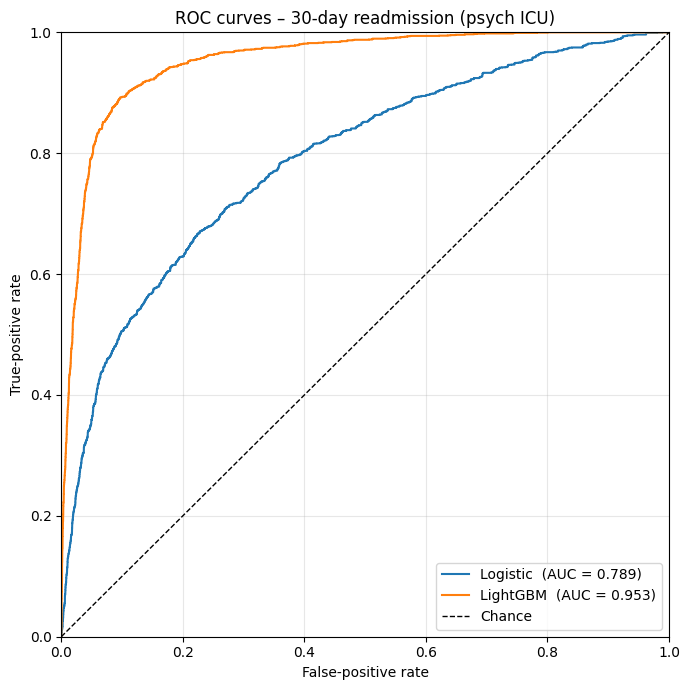

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def roc_points(model, X, y):
    """Return fpr, tpr, auc for a fitted pipeline."""
    p = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, p)
    return fpr, tpr, auc(fpr, tpr)

# compute points
fpr_log, tpr_log, auc_log = roc_points(logit, X_te, y_te.map({'False': 0, 'True': 1}))
fpr_gbm, tpr_gbm, auc_gbm = roc_points(gbm, X_te, y_te.map({'False': 0, 'True': 1}))

# plot
plt.figure(figsize=(7,7))
plt.plot(fpr_log, tpr_log, label=f'Logistic  (AUC = {auc_log:.3f})')
plt.plot(fpr_gbm, tpr_gbm, label=f'LightGBM  (AUC = {auc_gbm:.3f})')
plt.plot([0,1], [0,1], 'k--', lw=1, label='Chance')

plt.xlim(0, 1); plt.ylim(0, 1)
plt.xlabel('False-positive rate')
plt.ylabel('True-positive rate')
plt.title('ROC curves – 30-day readmission (psych ICU)')
plt.grid(alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

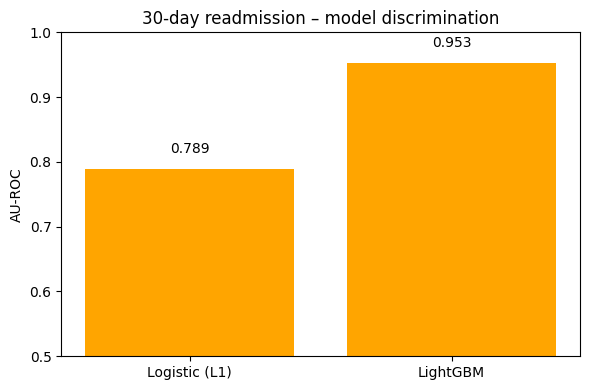

In [20]:
import matplotlib.pyplot as plt

# AU-ROC values from your last run
models = ['Logistic (L1)', 'LightGBM']
auc     = [0.7894,         0.9530]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, auc, color='orange')
plt.ylim(0.5, 1.0)
plt.ylabel('AU-ROC')
plt.title('30-day readmission – model discrimination')

# annotate each bar
for bar, v in zip(bars, auc):
    plt.text(bar.get_x() + bar.get_width()/2,
             v + 0.02,
             f'{v:.3f}',
             ha='center',
             va='bottom')

plt.tight_layout()
plt.show()


In [27]:
import pandas as pd, numpy as np
from pathlib import Path

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler, OneHotEncoder
from sklearn.compose        import ColumnTransformer
from sklearn.pipeline       import Pipeline
from sklearn.linear_model   import LogisticRegression
from sklearn.metrics        import roc_auc_score
from sklearn.inspection     import permutation_importance

from lightgbm import LGBMClassifier
import shap, warnings; warnings.filterwarnings("ignore")

root = Path("./data")

# ────────────────────────── 1. load files ───────────────────────
base      = pd.read_csv(root/"icu_psy_readmissions.csv",
                        parse_dates=["intime","outtime","dischtime","readmitted_30d"])
base = base.drop(columns=["next_admission"])  # drop this column
last_rx   = pd.read_csv(root/"last_prescriptions_processed.csv",
                        parse_dates=["last_psych_med_time"])
diag      = pd.read_csv(root/"psych_diagnoses.csv")

icu = pd.read_csv(
    "./data/icu/icustays.csv",
    usecols=["stay_id","subject_id","hadm_id","intime","outtime"],
    parse_dates=["intime","outtime"]
)


rx = pd.read_csv(
    "./data/psych_prescriptions.csv",
    parse_dates=["starttime","stoptime"],           # keep times
    low_memory=False
)
icu_unique = icu.drop_duplicates(subset=["subject_id", "hadm_id"])

rx = rx.merge(
    icu_unique, on=["subject_id", "hadm_id"], how="left",
    validate="many_to_one"  # each hadm_id → at most one stay_id
)
rx = rx[(rx["starttime"] >= rx["intime"] - pd.Timedelta("6h")) &
        (rx["starttime"] <= rx["intime"] + pd.Timedelta("1d"))]

patients  = pd.read_csv(root/"hosp/patients.csv",
                        usecols=["subject_id","gender","anchor_age"])

sofa      = pd.read_csv("./data/derived/first_day_sofa.csv")      # stay_id level
sirs      = pd.read_csv("./data/derived/sirs.csv")
charlson  = pd.read_csv("./data/derived/charlson.csv")  # hadm_id level

# ────────────────────────── 2. small feature engineering ────────
# ── load icustays (needed only for the merge) ───────────────────
icu = pd.read_csv(
    "./data/icu/icustays.csv",
    usecols=["stay_id","subject_id","hadm_id"]
)

# ── load diagnoses  (now with all columns) ─────────────────────
diag = pd.read_csv(
    "./data/psych_diagnoses.csv",
    usecols=["subject_id","hadm_id","icd_code","icd_version","psych_flag"]
)

# attach stay_id                                          
diag = diag.merge(
    icu.drop_duplicates(subset=["subject_id", "hadm_id"]),
    on=["subject_id", "hadm_id"],
    how="left",
    validate="many_to_one"
)

#   -- if a hadm_id maps to several stays, keep the one that has psych_flag = 1
#      (or just pick the first chronologically)
diag.sort_values(["subject_id","hadm_id","psych_flag"], ascending=[True,True,False], inplace=True)
diag = diag.drop_duplicates(subset=["subject_id","hadm_id"], keep="first")

# 2-a diagnoses → one-hot buckets
def icd_bucket(code: str) -> str:
    return str(code)[:3]                 # simple 3-digit bucket

diag["dx_group"] = diag["icd_code"].map(icd_bucket)
dx_onehot = (
    diag.groupby(["stay_id","dx_group"])
        .size().unstack(fill_value=0)
        .add_prefix("dx_")               # e.g. dx_296 mood disorder
        .reset_index()
)

# 2-b prescription counts per stay
rx_cnt = (
    rx.groupby("stay_id")
       .agg(n_psych_meds      = ("drug", "nunique"),
            total_psych_doses = ("doses_per_24_hrs", "sum"),
            iv_route_used     = ("route", lambda r: int((r=="IV").any())),
            max_daily_dose    = ("doses_per_24_hrs", "max"))
       .reset_index()
)

# 2-c last Rx gap (h)
gap = (
    base.loc[:, ["stay_id","hadm_id","dischtime"]]          # dischtime is in base
        .merge(last_rx, on="hadm_id", how="left", validate="many_to_one")
        .assign(
            gap_hr = lambda d:
                (d["dischtime"] - d["last_psych_med_time"])
                  .dt.total_seconds()/3600
        )
        .loc[:, ["stay_id","gap_hr"]]
)



# 2-d ICU scores already computed
# sofa, sirs: merge on stay_id; charlson on hadm_id later

# ────────────────────────── 3. merge everything ─────────────────
df = (
    base
      .merge(patients, on="subject_id", how="left")
      .merge(sofa, on="stay_id", how="left")
      .merge(sirs, on="stay_id", how="left")
      .merge(charlson.drop(columns=["subject_id"]), on="hadm_id", how="left")
      .merge(dx_onehot, on="stay_id", how="left")
      .merge(rx_cnt, on="stay_id", how="left")
      .merge(gap, on="stay_id", how="left")
)
df.fillna(0, inplace=True)       # quick pass; choose smarter later

# target must be 0/1 already in base
y  = df.pop("readmitted_30d")
X  = df.drop(columns=["intime","outtime","dischtime"])  # drop raw dates

num = X.select_dtypes("number").columns.to_list()
cat = X.select_dtypes("object").columns.to_list()

# ────────────────────────── 4. train / test split ───────────────
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

pre = ColumnTransformer([
        ("num", StandardScaler(), num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat)
])

# ────────────────────────── 5-A. L1-logistic (transparent) ──────
logit = Pipeline([
        ("pre", pre),
        ("clf", LogisticRegression(
                    penalty="l1", solver="saga",
                    class_weight="balanced", max_iter=500))
])
# Cast categorical features to string to avoid type mixing issues.
for col in ['first_careunit', 'last_careunit', 'gender']:
    X_tr[col] = X_tr[col].astype(str)
    X_te[col] = X_te[col].astype(str)

logit.fit(X_tr, y_tr)
print("Logistic AUC:", roc_auc_score(y_te, logit.predict_proba(X_te)[:, 1]))

pi = permutation_importance(logit, X_te, y_te, n_repeats=20, random_state=0)
imp_log = (pd.Series(pi.importances_mean, index=X_te.columns)
           .sort_values(ascending=False).head(15))
print("\nTop logit drivers:")
print(imp_log)
print(imp_log)

# ────────────────────────── 5-B. LightGBM + SHAP (non-linear) ───
gbm = Pipeline([
        ("pre", pre),
        ("clf", LGBMClassifier(
                    n_estimators=400, learning_rate=0.05,
                    num_leaves=31, class_weight="balanced",
                    random_state=42))
])
gbm["clf"].fit(
    gbm["pre"].fit_transform(X_tr),
    y_tr,
    feature_name=list(gbm["pre"].get_feature_names_out())
)
print("\nLightGBM AUC:", roc_auc_score(y_te, gbm.predict_proba(X_te)[:,1]))

expl = shap.TreeExplainer(gbm["clf"])
X_te_enc = gbm["pre"].transform(X_te)
if sparse.issparse(X_te_enc):
    X_te_enc = X_te_enc.toarray()
sh = expl.shap_values(X_te_enc, check_additivity=False)[1]
# Convert the sparse shap values to a dense 1D array before creating the DataFrame
sh_array = np.abs(sh).mean(axis=0)
if hasattr(sh_array, "A1"):
    sh_array = sh_array.A1  # convert to 1D numpy array
else:
    sh_array = np.asarray(sh_array).flatten()

feat_names = gbm["clf"].booster_.feature_name()
expl      = shap.TreeExplainer(gbm["clf"])
sh_vals   = expl.shap_values(X_te_enc, check_additivity=False)[1]   # (n,f)

sh_imp = (pd.DataFrame({"feature": feat_names,
                        "mean_abs_shap": np.abs(sh_vals).mean(0)})
          .sort_values("mean_abs_shap", ascending=False)
          .head(15))
print("\nTop SHAP drivers:")
print(sh_imp)


Logistic AUC: 0.7893662369575988

Top logit drivers:
dx_305        0.122815
dx_F32        0.066461
dx_F41        0.063100
dx_F17        0.055561
dx_F10        0.049156
dx_303        0.032287
dx_296        0.028953
anchor_age    0.015378
dx_F11        0.013397
dx_295        0.010893
dx_304        0.009911
dx_F31        0.007397
gap_hr        0.005882
los           0.005865
dx_F43        0.004562
dtype: float64
dx_305        0.122815
dx_F32        0.066461
dx_F41        0.063100
dx_F17        0.055561
dx_F10        0.049156
dx_303        0.032287
dx_296        0.028953
anchor_age    0.015378
dx_F11        0.013397
dx_295        0.010893
dx_304        0.009911
dx_F31        0.007397
gap_hr        0.005882
los           0.005865
dx_F43        0.004562
dtype: float64
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8775, number of negative: 50490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of tes

## Logistic
dx_305
ICD-9 305
Non-dependent abuse of drugs (e.g. cannabis, stimulants, sedatives without physiologic dependence)
dx_F32
ICD-10 F32
Major depressive episode
dx_F41
ICD-10 F41
Other anxiety disorders (GAD, panic disorder, etc.)
dx_F17
ICD-10 F17
Nicotine-dependence / tobacco use disorder
dx_F10
ICD-10 F10
Alcohol-related disorders
dx_303
ICD-9 303
Alcohol dependence syndrome
dx_296
ICD-9 296
Affective psychoses – bipolar, major depression, manic psychosis
anchor_age
—
Age (years) at index ICU admission
dx_F11
ICD-10 F11
Opioid-related disorders
dx_295
ICD-9 295
Schizophrenia
dx_304
ICD-9 304
Drug dependence (physiologic)
dx_F31
ICD-10 F31
Bipolar affective disorder
gap_hr
—
Hours between last inpatient psych med and hospital discharge
los
—
Length-of-stay for the ICU stay (hours)
dx_F43
ICD-10 F43
Reaction to severe stress & adjustment disorders

## LightGBM
num__dx_F53
ICD-10 F53 – Post-partum mental & behavioural disorders
num__dx_F70
ICD-10 F70 – Mild intellectual disability
num__dx_F30
ICD-10 F30 – Manic episode
num__dx_F88
ICD-10 F88 – Other disorders of psychological development
num__dx_F81
ICD-10 F81 – Specific developmental disorders of scholastic skills
num__dx_F29
ICD-10 F29 – Unspecified non-organic psychosis
num__dx_F91
ICD-10 F91 – Conduct disorders
num__dx_F51
ICD-10 F51 – Sleep disorders not due to a substance or known physiologic condition
num__dx_F72
ICD-10 F72 – Severe intellectual disability
num__dx_F54
ICD-10 F54 – Psychological factors associated with disorders
num__dx_F13
ICD-10 F13 – Sedative/hypnotic/anxiolytic-related disorders
num__dx_F78
ICD-10 F78 – Other intellectual disabilities
num__dx_F71
ICD-10 F71 – Moderate intellectual disability
num__dx_F44
ICD-10 F44 – Dissociative (conversion) disorders
